In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import statsmodels.api as sm
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

import warnings
import os
from itertools import product

from src.plots import *
from src.metrics import *

warnings.filterwarnings('ignore')

### Base Line Model Building
Let's take a look at the resulting series and try to make a prediction using models with default parameters (SARIMA, LinearRegression and XGBoost)

In [6]:
# Main Directory 
DATA_SOURCE = '' # provide path to processed_data
os.chdir(DATA_SOURCE)

In [7]:
# Data Reading
data = pd.read_csv('processed_ts_main.csv', parse_dates=['tpep_pickup_datetime'])
data

,tpep_pickup_datetime,PULocationID,n_trips
0,2020-01-01 00:00:00,4,10
1,2020-01-01 00:00:00,189,1
2,2020-01-01 00:00:00,186,26
3,2020-01-01 00:00:00,185,1
4,2020-01-01 00:00:00,181,7
...,...,...,...
3620587,2021-07-31 23:00:00,135,0
3620588,2021-07-31 23:00:00,134,0
3620589,2021-07-31 23:00:00,133,0
3620590,2021-07-31 23:00:00,219,0


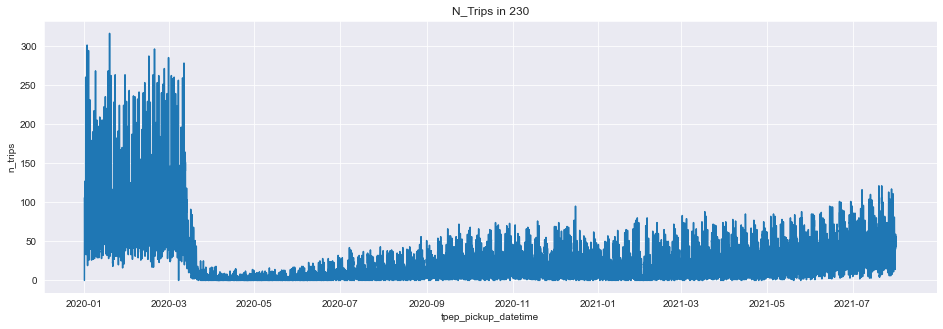

In [8]:
# Visualize Time Series for district 230 
plot_series(data.query('PULocationID == 230'), city_zone=230)

We see a big decline in March-April. This can be explained by the coronavirus and the lockdown. Such a decline is observed in all obtained time series with a sufficient number of data

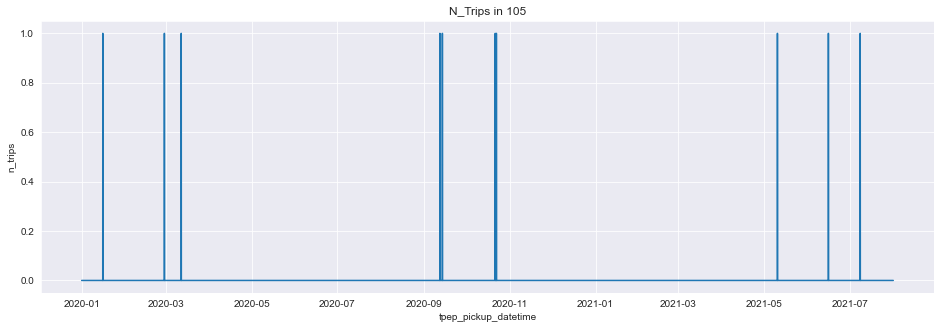

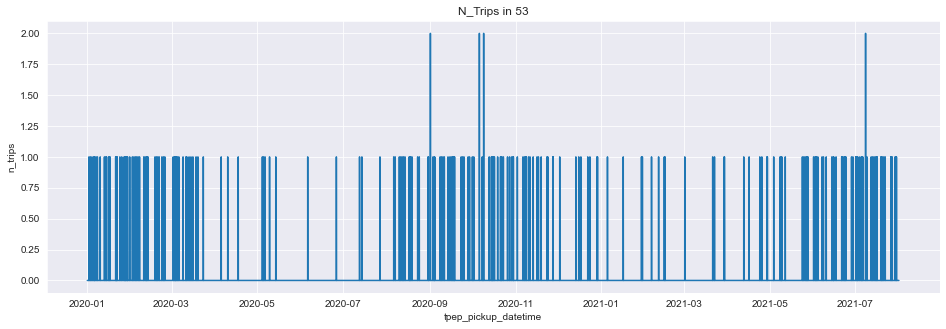

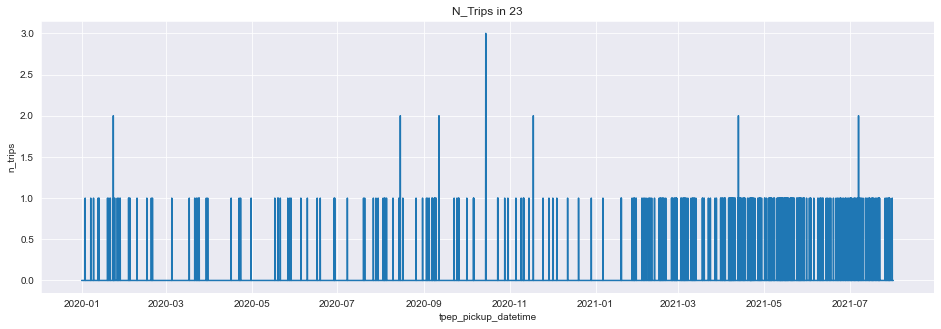

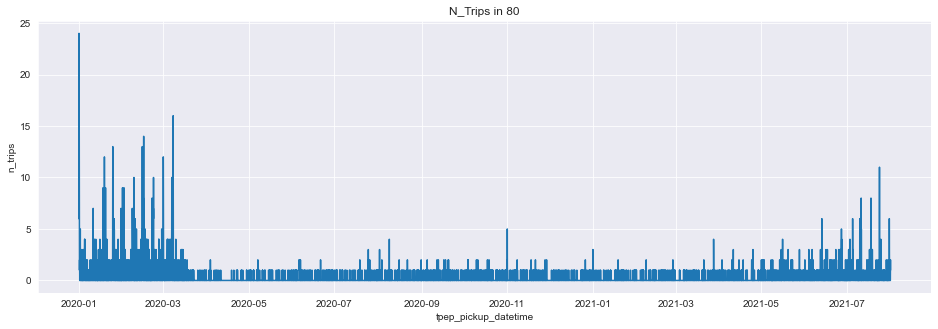

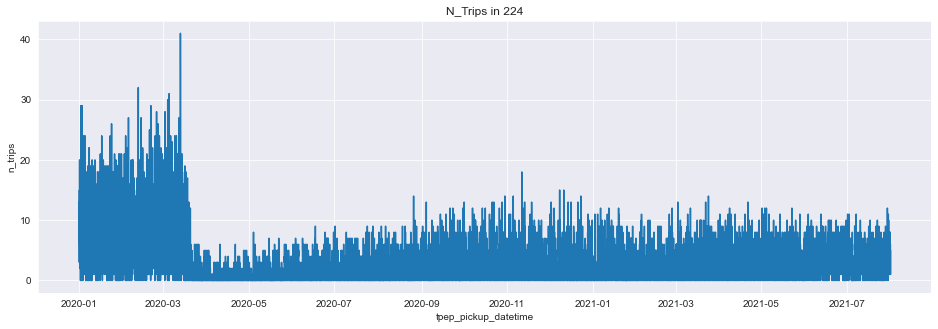

In [10]:
# let's look at 5 random series (!Districts 103 и 104 are excluded)
rand_zones = np.random.randint(1, 264, 5)
for zone in rand_zones:
    plot_series(data.query(f'PULocationID == {zone}'), city_zone=zone)

### Forecasting for Districts 230 (Times Sq/Theatre District)

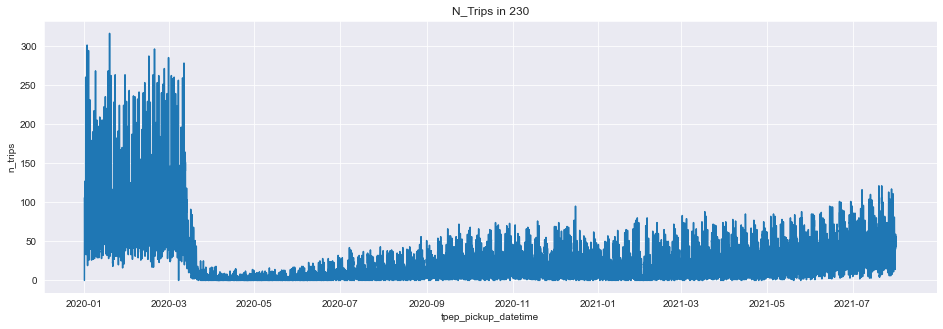

In [11]:
# Select the District
df = data[data['PULocationID'] == 230]

# Visualize the Series 
plot_series(df, city_zone=230)

In [12]:
# Forecast 1 month ahead (July)
dt_start = pd.to_datetime('2020-01-01 00:00:00')
dt_end = pd.to_datetime('2021-06-30 23:00:00')
target_dates = pd.date_range(dt_start, dt_end, freq = 'h')

# Train 
df_train = df[df['tpep_pickup_datetime'].isin(target_dates)].sort_values(by='tpep_pickup_datetime')
df_train = df_train.set_index('tpep_pickup_datetime').drop(columns=['PULocationID'])

# Test (2021-07-01)
df_test = df[~df['tpep_pickup_datetime'].isin(target_dates)].sort_values(by='tpep_pickup_datetime')
df_test = df_test.set_index('tpep_pickup_datetime').drop(columns=['PULocationID'])

Let's take a look at the decomposition of the time series

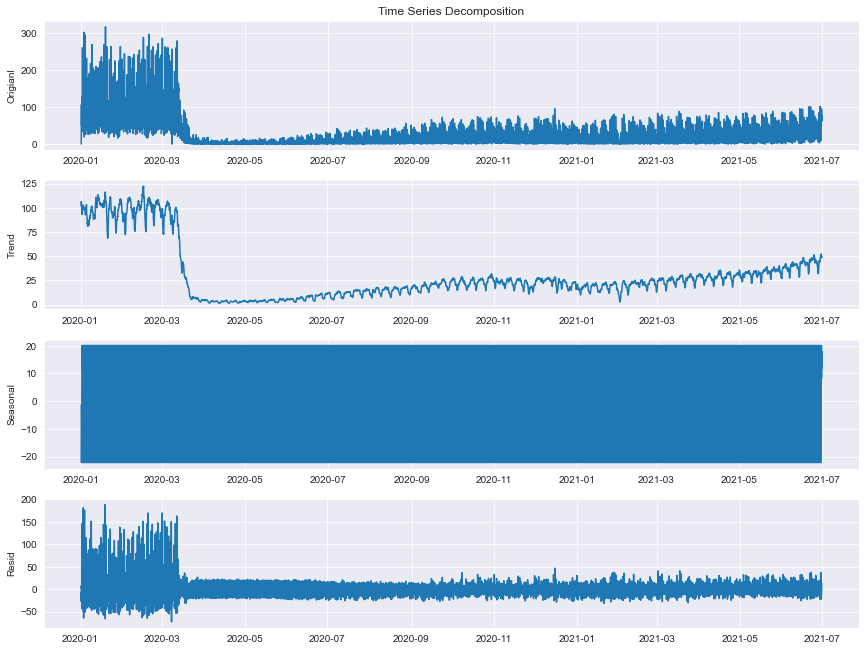

In [13]:
plot_decomposition(df_train['n_trips'])

Time Series Decomposition shows that a **non-linear trend is strongly pronounced**. Very fast drop (coronavirus) then smooth rise. **Dispersion of the series is unstable** (large fluctuations). It is difficult to say something about seasonality. **Residuals are displaced and non-stationary.**

### Regression Features 
Create regression features to take into account seasonality and trends

The main difficulty in working with such a series is how to take into account the complex structure of seasonality - daily, weekly and annual. **Within ARIMA models, only one of them can be taken into account.** Typically, in such cases, **seasonality with the shortest period** is explicitly modelled using ARIMA, and all the others are taken into account due to the regression component.

To take into account weekly seasonality, regression features of the following type are used:

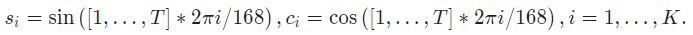

- `T`: Time Series length
- `168`: Length of the week in hours (weekly seasonality)
- `K`: Hyperparameter (depends on the length of the series, initial approximation 2-5, number of new features)

Seasonality: hourly, weekly, monthly, annual.

In [14]:
# Harmonics Series Computation 
def get_regression_features(func, T, season_length, K):
    if func == 'sin': func = np.sin
    elif func == 'cos': func = np.cos
    else: print('Only sin/cos functions are allowed')
    features = []
    ts_length = np.arange(1, T+1)
    for i in range(1, K+1):
        features.append(func((ts_length * 2 * np.pi * i)/season_length))
    return np.array(features)

For the ARIMA model, we need to choose an order of differentiation. For this purpose, we will build a regression of the target feature on the features obtained by the `get_regression_features()` function. Then we look at the residuals of the regression.

If the regression features are perfectly matched, then only intraday seasonality should remain in them, otherwise - holidays, anomalies, trends, and much more (structure)

In [15]:
# let's have a look at basline with season_length = 168 and K = 5
# Create a function for convinience
def get_reg_features_df(df, season_length=168, K=5):
    features_df = pd.concat([pd.DataFrame(get_regression_features(func, T=df.shape[0], season_length=season_length, K=K).T) for func in ['sin', 'cos']],
                              axis='columns')

    features_df.columns = [f'sin_{i}_{season_length}'for i in range(K)] + [f'cos_{i}_{season_length}'for i in range(K)]
    return features_df

features_df = get_reg_features_df(df=df_train)

In [16]:
# Train Data 
X = features_df.values
y = df_train['n_trips']

# Training
model = LinearRegression()
model.fit(X, y)

print('R2 Train: ', model.score(X, y))
print('R2 Adj: ', adjusted_rsquare(y, model.predict(X), X=X))

R2 Train:  0.008261736794184515
R2 Adj:  0.007505665845639942


Obtained a very low `R2`. Let's take a look at the model residuals 

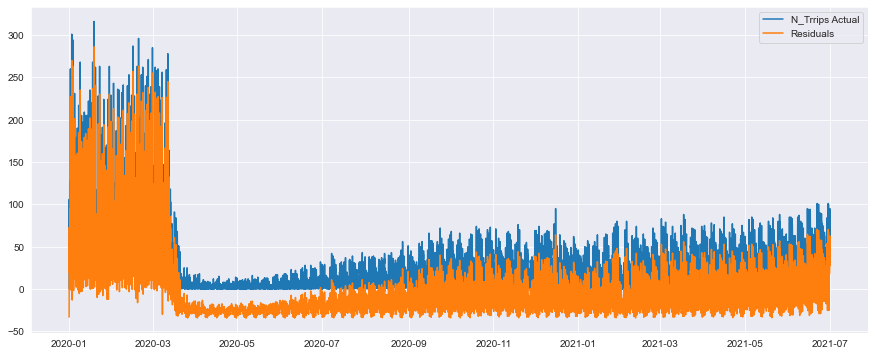

In [17]:
# Visualize model residuals
residuals = y - model.predict(X)

plt.figure(figsize=(15,6))
plt.plot(y, label='N_Trrips Actual')
plt.plot(residuals, label='Residuals')
plt.legend()
plt.grid(True);

It can be seen that a lot of structure is still preserved in the model residuals. Therefore, the current features are not enough.

Let's enumerate the values of K

In [18]:
r2_scores = []
for K in range(1,51):
    features_df = get_reg_features_df(df=df_train, K=K)
    X = features_df.values
    y = df_train['n_trips']
    model = LinearRegression()
    model.fit(X,y)
    r2_scores.append([K, model.score(X,y)])

scores_df = pd.DataFrame(r2_scores)
scores_df.columns = ['n_features', 'r2_score']

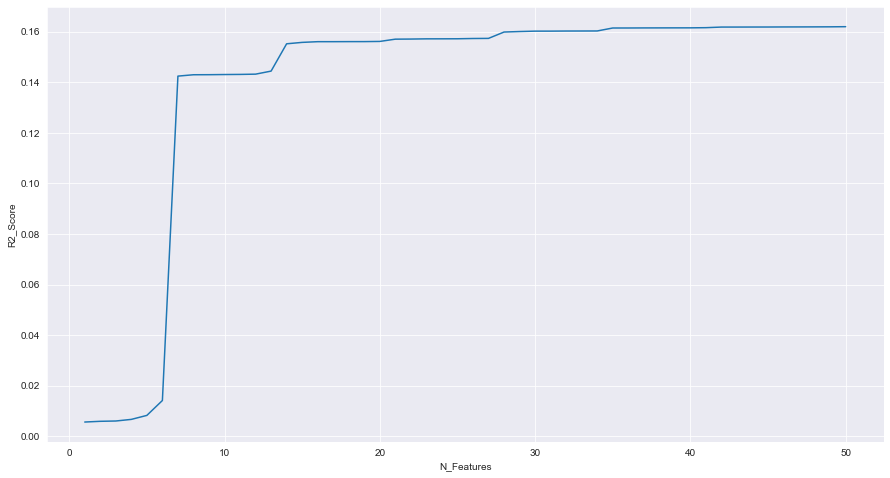

In [19]:
plt.figure(figsize=(15,8))
plt.plot(scores_df['n_features'], scores_df['r2_score'])

plt.grid(True)
plt.xlabel('N_Features')
plt.ylabel('R2_Score')
plt.show()

A good feature number is the `K=25/30` span. Let's take a look at the residuals with `K=30`

In [20]:
features_df = get_reg_features_df(df=df_train, K=30)

# Train
X = features_df.values
y = df_train['n_trips']

# Training 
model = LinearRegression()
model.fit(X, y)

print('R2 Train: ', model.score(X, y))
print('R2 Adj: ', adjusted_rsquare(y, model.predict(X), X=X))

# Visualize model residuals
residuals = y - model.predict(X)

R2 Train:  0.16018915060481687
R2 Adj:  0.15633297466820462


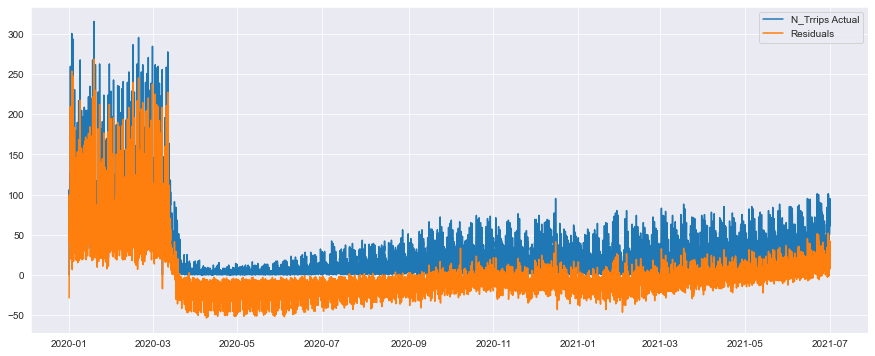

In [21]:
# Visualize
plt.figure(figsize=(15,6))

plt.plot(y, label='N_Trrips Actual')
plt.plot(residuals, label='Residuals')
plt.legend()
plt.grid(True);

If we predict only using a regression model, then the number of features can be made arbitrarily large:
- Add hourly harmonics
- Add weekly harmonics
- Add annual harmonics

In [22]:
f_df = pd.DataFrame()
season_length = [24, 168, 8064]
for length in season_length:
    features_df = get_reg_features_df(df=df_train, K=30, season_length=length)
    f_df = pd.concat([f_df, features_df], axis='columns')

In [23]:
# Train Data
X = f_df.values
y = df_train['n_trips']

# Training 
model = LinearRegression()
model.fit(X, y)

print('R2 Train: ', model.score(X, y))
print('R2 Adj: ', adjusted_rsquare(y, model.predict(X), X=X))

# Visualize model residuals
residuals = y - model.predict(X)

R2 Train:  0.40916300720530185
R2 Adj:  0.40094869819911927


Features with annual seasonality can greatly increase `R2` (by 2 times). It can be seen that the residuals have changed their shape (we've taken into account the weekly and annual seasonality), but there are still non-linear trends and structure.

Need more features

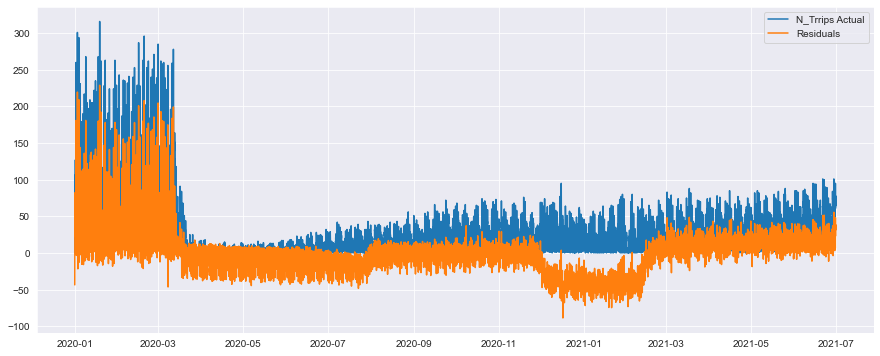

In [24]:
plt.figure(figsize=(15,6))

plt.plot(y, label='N_Trrips Actual')
plt.plot(residuals, label='Residuals')
plt.legend()
plt.grid(True);

With such features, we get relatively good quality. But we will model seasonality with the shortest period using ARIMA, hence we are interested in `seasonal_length=168`

In [25]:
features_df = get_reg_features_df(df=df_train, K=30)

X = features_df.values
y = df_train['n_trips']

model = LinearRegression()
model.fit(X, y)
residuals = y - model.predict(X)

For the hyperparameter selection of the ARIMA model, it is necessary to achieve stationarity of the residuals:
- Multiple differentiations

When choosing the order of differentiation, we will focus on the results of the Time Series STL decomposition

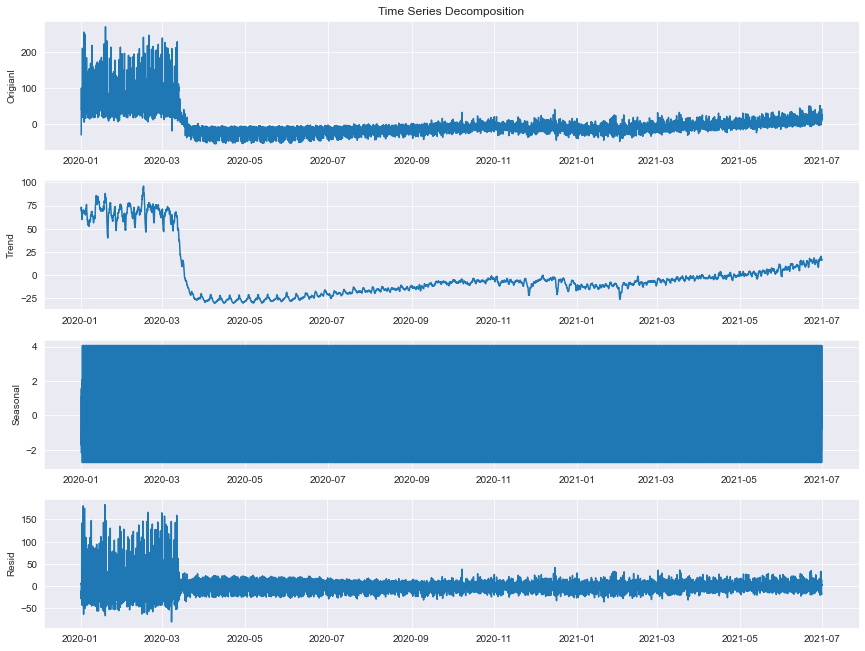

In [26]:
# STL - decomposition
resid_df = pd.DataFrame(residuals.values, columns=['residuals'], index=residuals.index)
plot_decomposition(resid_df['residuals'])

In [27]:
# Apply seasonal differentiation. Season length (168h, week)
resid_df['resid_diff_168'] = resid_df['residuals'] - resid_df['residuals'].shift(168)

Критерий Дики-Фуллера: p=0.000000


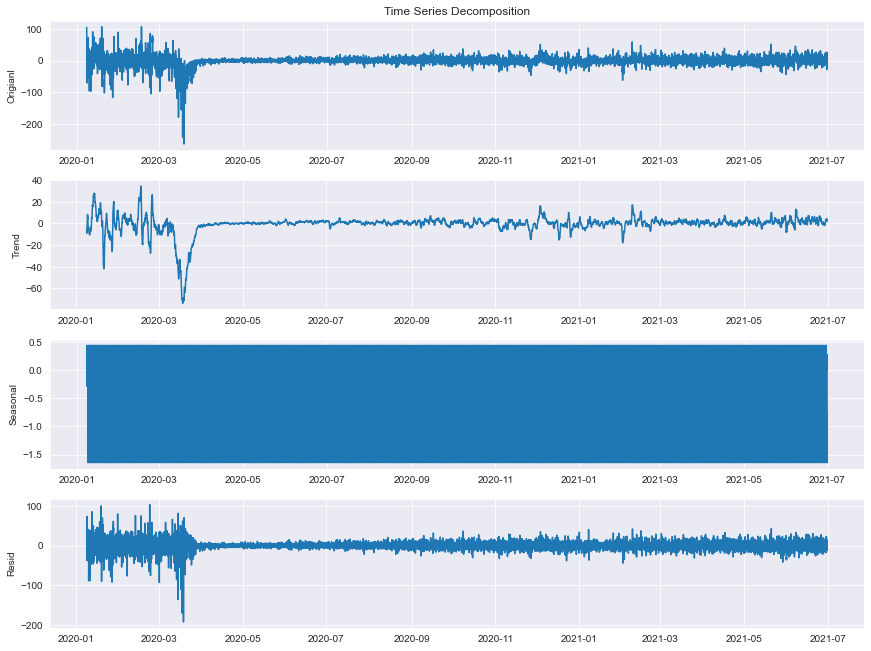

In [28]:
# Look at decomposition
plot_decomposition(resid_df['resid_diff_168'][168:])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid_df.loc[resid_df.index[168:], 'resid_diff_168'])[1])

The trend is already looking better and hovering around zero. We also see an anomaly in the trend (coronavirus). The Dickey-Fuller criterion denies the non-stationarity of the series, but it would be nice to apply the first or seasonal differences as well

In [29]:
# Apply seasonal differentiation. Season length 24 (day)
resid_df['resid_diff_168_24'] = resid_df['resid_diff_168'] - resid_df['resid_diff_168'].shift(24)

Критерий Дики-Фуллера: p=0.000000


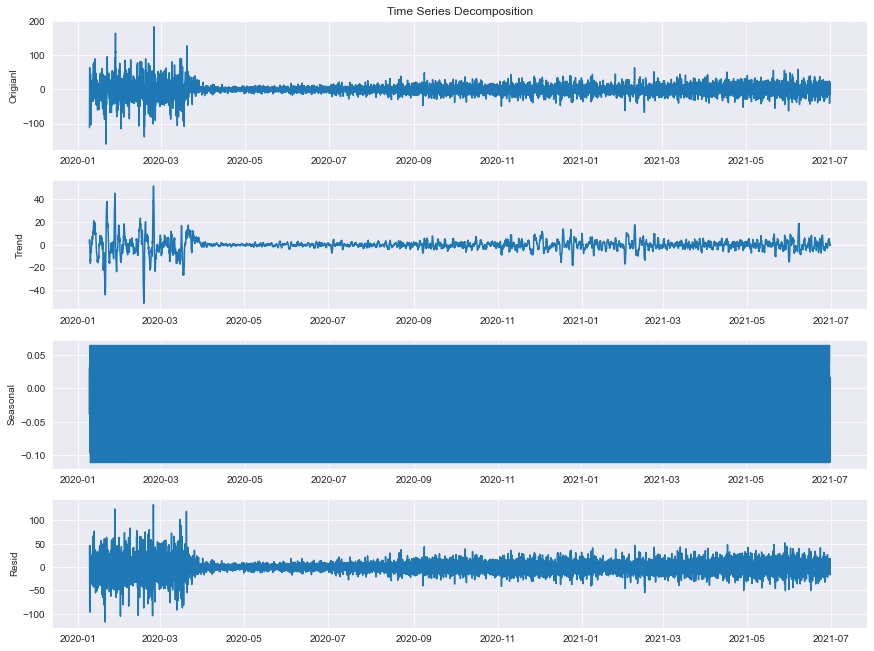

In [30]:
# Look at decomposition
plot_decomposition(resid_df['resid_diff_168_24'][192:])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid_df.loc[resid_df.index[192:], 'resid_diff_168_24'])[1])

Much better, but still tricky with the seasonal component

Now let's define the initial approximations of the ARIMAX model. To do this, plot the `ACF` and `PACF` graphs of the resulting series of residuals (differentiated) with a maximum lag no less than the length of the longest seasonal period (a week or a year)

We will pass regression features using the `exog` parameter

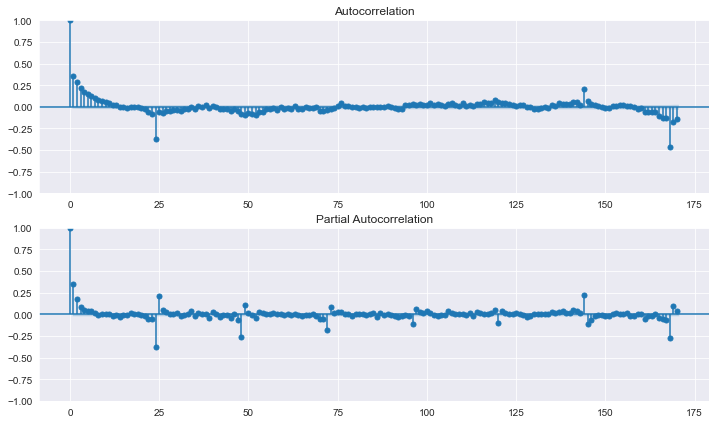

In [31]:
plot_acf_pacf(resid_df['resid_diff_168_24'].iloc[192:], lags=170)

For better visibility

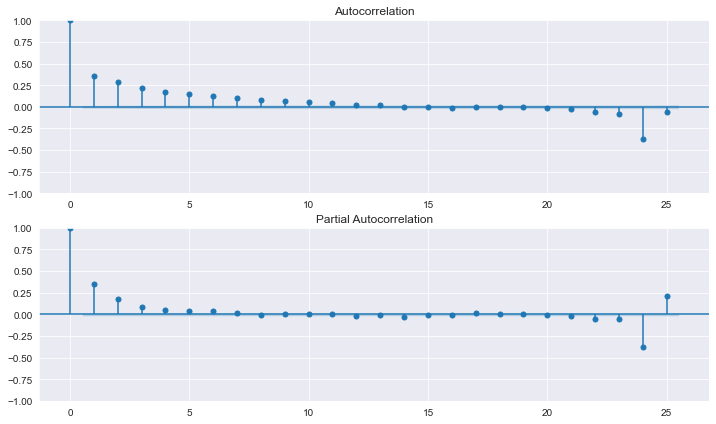

In [32]:
plot_acf_pacf(resid_df['resid_diff_168_24'].iloc[192:], lags=25)

According to the ACF graph, we will determine the initial approximations q and Q:

- Q: 1 (maximum seasonal lag that is significant given the length of the season: 168/24*7)
- q: 11 (maximum non-seasonal lag that is significant)

According to the PACF schedule, we will determine the initial approximations for p and P:

- P: 1 (maximum seasonal lag that is significant, given the length of the season, lag 168 is significant: 168/168=1)
- p: 4 (maximum non-seasonal lag that is significant)

Considering now our initial approximations, we enumerate these parameters for the model

In [33]:
# Found Parameters
Q, q = 1, 1 # set q = 1, insted of 11 because number of models becomes 310 (too large)
P, p = 1, 5
D, d = 1, 1
s = 24

# Set Initial Approximation
ps = range(0, p+1)
qs = range(0, q+1)
Ps = (0, P+1)
Qs = (0, Q+1)

# Let's look at the total number of combinations
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print('Total Params Combinations: ', len(parameters_list))

Total Params Combinations:  48


First, let's build a model with the number of features `K=5`. Then choose `K=30` and compare the quality

In [34]:
# K=5
features_df = get_reg_features_df(df=df_train, K=5)

In [35]:
%%time

results = []
best_aic = float("inf")
exog = sm.add_constant(features_df) # obtained features

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(df_train['n_trips'].values,
                                          order=(param[0], d, param[1]), # p,d,q params
                                          seasonal_order=(param[2], D, param[-1], s), # P,D,Q,s
                                          exog=exog).fit(disp=-1)
    # Обрабатываем ошибки 
    except ValueError:
        print('Wrong Params: ', param)
        continue
    except LinAlgError:
        print('Singular matrix:', param)
        continue
        
     # Look at the values of the Akaike information criterion and save the best model
    current_aic = model.aic
    if current_aic < best_aic:
        best_model = model
        best_aic = current_aic
        best_param = param
        
    results.append([param, model.aic])

It takes much time to calculate a large series using ARIMA and select the optimal parameters. For example, enumeration of 48 parameters will take more than 12 hours

It is necessary to use other models, such as **linear regression or XGBoost**, and predict using good features

In [36]:
# Select district 
df = data[data['PULocationID'] == 230]
df = df.set_index('tpep_pickup_datetime').drop(columns=['PULocationID'])
df

,n_trips
tpep_pickup_datetime,
2020-01-01 00:00:00,0
2020-01-01 01:00:00,27
2020-01-01 02:00:00,43
2020-01-01 03:00:00,106
2020-01-01 04:00:00,99
...,...
2021-07-31 19:00:00,43
2021-07-31 20:00:00,46
2021-07-31 21:00:00,48


In [37]:
# Functions for generating features from TS
def code_mean(data, cat_feature, target_feature):
    """
    Returns a dictionary where the keys are the unique categories of the feature cat_feature,
    and the values are the averages for real_feature
    """
    return dict(data.groupby(cat_feature)[target_feature].mean())


def prepare_data(data, target_col, dt_start_train, dt_end_train, lag_start=5, lag_end=20):
    data = pd.DataFrame(data.copy())
    
    # Split Train/Test
    target_dates = pd.date_range(dt_start, dt_end, freq = 'h')
    
    # Lags of the series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data[target_col].shift(i)
        
    # Features (Hour, Day of the Week, Weekend? (0/1) )
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1 # Multiply by 1 to get 0/1 instead of True/False
    
    # Mean encoding (Encode only Train)
    data['weekday_average'] =  list(map(code_mean(data[:target_dates[-1]], 'weekday', target_col).get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:target_dates[-1]], 'hour', target_col).get, data.hour))
    
    # We do not need features (because they are encoded)
    data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # Train 
    train_df = data[data.index.isin(target_dates)]
    train_df = train_df.dropna()
    train_df = train_df.reset_index(drop=True)
    
    X_train = train_df.drop([target_col], axis=1)
    y_train = train_df[target_col]
    
    # Test
    test_df = data[~data.index.isin(target_dates)]
    test_df = test_df.dropna()
    test_df = test_df.reset_index(drop=True)
    
    X_test = test_df.drop([target_col], axis=1)
    y_test = test_df[target_col]
    
    return X_train, X_test, y_train, y_test

In [38]:
# Forecast 1 month ahead (for July)
dt_start = pd.to_datetime('2020-01-01 00:00:00')
dt_end = pd.to_datetime('2021-06-30 23:00:00')


X_train, X_test, y_train, y_test = prepare_data(data=df,
                                                target_col='n_trips',
                                                dt_start_train=dt_start,
                                                dt_end_train=dt_end,
                                                lag_start=5,
                                                lag_end=20)

Build Models:
- Linear Regression
- XGBoost

### Linear Regression

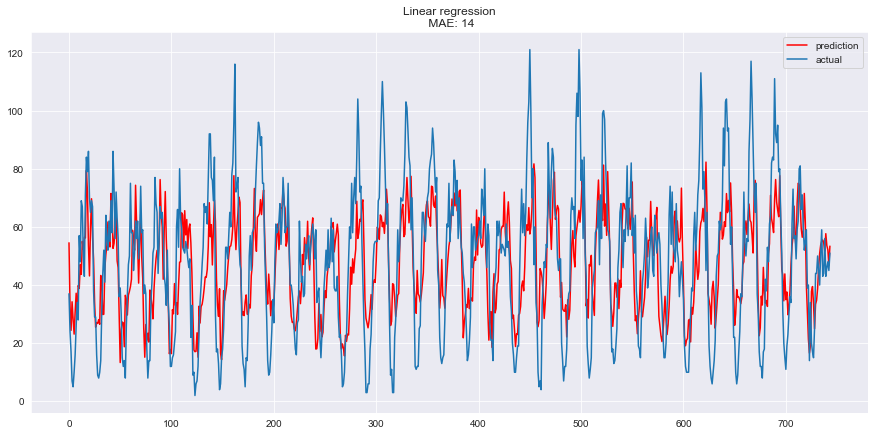

In [39]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

mae = round(mean_absolute_error(preds, y_test.values))

plt.figure(figsize=(15, 7))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")

plt.title(f"Linear regression\n MAE: {mae}")
plt.grid(True);

We got a relatively good baseline solution. On average, we are mistaken by 14 trips, which is a lot, but we have a small number of features

### XGBoost

In [40]:
# Train/Test
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# Model Parameters
params = {
    'objective': 'reg:linear',
    'booster':'gblinear'
}

trees = 1000

In [41]:
# Use cross-validation with rmse metric
cv = xgb.cv(params, dtrain, metrics = ('mae'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

# Train xgboost with the optimal number of trees selected on cross-validation
bst = xgb.train(params, dtrain, num_boost_round=cv['test-mae-mean'].argmin())

[23:56:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:17

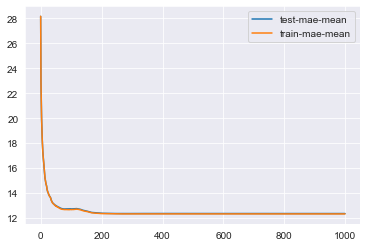

In [42]:
#Validation Curves
cv.plot(y=['test-mae-mean', 'train-mae-mean']);

In [43]:
# CV error
deviation = cv.loc[cv['test-mae-mean'].argmin()]["test-mae-mean"]

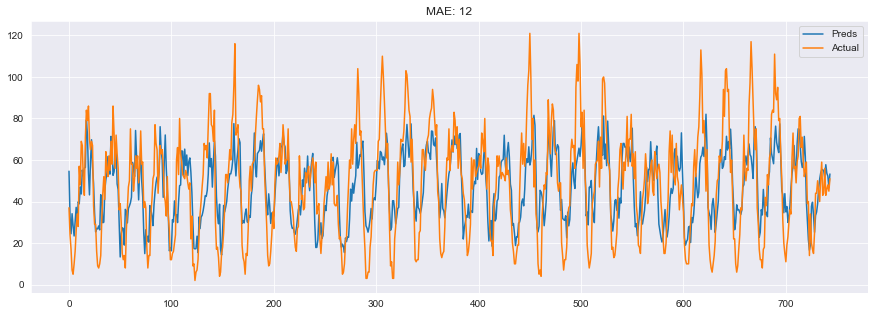

In [44]:
prediction_test = bst.predict(dtest)
plt.figure(figsize=(15, 5))
plt.plot(prediction_test, label='Preds')
plt.plot(list(y_test), label="Actual")
plt.axis('tight')
plt.grid(True)
plt.title(f'MAE: {round(deviation)}')
plt.legend();

The quality has gotten a little better. However, we have built a model for only 1 series, and we have more than 200 of them. Next, we will cluster the time series and build a model for the whole cluster.